In [1]:
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice
import seaborn as sns
from zipfile import ZipFile

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.layers import Embedding, LSTM, Dense, SimpleRNN, Bidirectional
from keras import Sequential, backend
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

random_state=113
%matplotlib inline

tf.random.set_seed(random_state)

imdb_model_list=list()
twitter_model_list=list()

2023-05-08 18:18:48.965691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


############################

# Part-A

############################

## 1. Import and analyse the data set.

In [2]:
top_words = 10000
(X_imdb_train, y_imdb_train), (X_imdb_test, y_imdb_test) = imdb.load_data(num_words=top_words, seed=random_state)

In [3]:
print(f"X_train have {X_imdb_train.shape[0]} rows")
print(f"X_test have {X_imdb_test.shape[0]} rows")
print(f"y_train have {y_imdb_train.shape[0]} rows")
print(f"y_test have {y_imdb_test.shape[0]} rows")

X_train have 25000 rows
X_test have 25000 rows
y_train have 25000 rows
y_test have 25000 rows


In [4]:
# Positive/Negative Reviews as values
print("Y train values: ",np.unique(y_imdb_train))
print("Y test values: ",np.unique(y_imdb_test))

Y train values:  [0 1]
Y test values:  [0 1]


In [5]:
# Distribution of y_imdb_train set
pd.Series(y_imdb_train).value_counts()

1    12500
0    12500
dtype: int64

In [6]:
# Distribution of y_imdb_test set
pd.Series(y_imdb_test).value_counts()

0    12500
1    12500
dtype: int64

In both dataset of targets, freq in equally distributed.

In [7]:
# Retrieves a dict mapping words to their index in the IMDB dataset.
imdb_dict = imdb.get_word_index()
print("IMDB dataset have",len(imdb_dict),"words index mappings.")

IMDB dataset have 88584 words index mappings.


In [8]:
# Printing 1st 10 mappings
list(islice(imdb_dict.items(), 10))

[('fawn', 34701),
 ('tsukino', 52006),
 ('nunnery', 52007),
 ('sonja', 16816),
 ('vani', 63951),
 ('woods', 1408),
 ('spiders', 16115),
 ('hanging', 2345),
 ('woody', 2289),
 ('trawling', 52008)]

In [9]:
"""
Use the default parameters to keras.datasets.imdb.load_data
start_char = 1  #The start of a sequence will be marked with this character.
oov_char = 2    #The out-of-vocabulary character.
index_from = 3  #Index actual words with this index and higher.
"""
start_char = 1
oov_char = 2
index_from = 3
def index_to_words(idx):
    reverse_index = dict((index+index_from,word) for (word,index) in imdb_dict.items())
    reverse_index[start_char] = "[START]"
    reverse_index[oov_char] = "[OOV]"

    decode_review = " ".join(reverse_index.get(i) for i in X_imdb_train[idx] if reverse_index.get(i) is not None)

    return "Paragraph: "+decode_review, "Label: "+str(y_imdb_train[idx])

In [10]:
# Checking review index 1
index_to_words(1)

("Paragraph: [START] big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal [OOV] the hair is big lots of boobs [OOV] men wear those cut [OOV] shirts that show off their [OOV] sickening that men actually wore them and the music is just [OOV] trash that plays over and over again in almost every scene there is trashy music boobs and [OOV] taking away bodies and the gym still doesn't close for [OOV] all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then",
 'Label: 

In [11]:
# Checking review index 99
index_to_words(99)

("Paragraph: [START] steve carpenter cannot make horror movies first of all the casting was very wrong for this movie the only decent part was the hot brown haired girl from buffy the vampire [OOV] this movies has no gore usually a key [OOV] to a horror movie no action no acting and no suspense also a key [OOV] wes [OOV] is a good actor but he is so dry and plain in this that it's sad there were a few parts that were supposed to be funny continuing the teen horror comedy movies and no one laughed in the audience i thought that this movie was rated r and i didn't pay attention and realized it had been changed to pg 13 anyway see this movie if you liked i still know what you did last summer that's the only type of person who would find this movie even remotely scary and seriously this is to you steve carpenter stop making horror movies this movie makes scream look like texas chainsaw massacre",
 'Label: 0')

## 2. Perform relevant sequence adding on the data.
## 3. Perform following data analysis:
- ### Print shape of features and labels
- ### Print value of any one feature and it's label

## 4. Decode the feature value to get original sentence

In [12]:
# truncate and pad input sequences using pad_sequences
max_review_length = 500
X_imdb_train = pad_sequences(X_imdb_train, maxlen=max_review_length)
# , padding='post', truncating='post')
X_imdb_test = pad_sequences(X_imdb_test, maxlen=max_review_length)
# , padding='post', truncating='post')

In [13]:
print(f"X_train have {X_imdb_train.shape[0]} rows and {X_imdb_train.shape[1]} columns after pad sequences")
print(f"X_test have {X_imdb_test.shape[0]} rows and {X_imdb_test.shape[1]} columns after pad sequences")

X_train have 25000 rows and 500 columns after pad sequences
X_test have 25000 rows and 500 columns after pad sequences


In [14]:
print(f"y_train have {y_imdb_train.shape[0]} rows")
print(f"y_test have {y_imdb_test.shape[0]} rows")

y_train have 25000 rows
y_test have 25000 rows


In [15]:
# Printing feature for random index 0
X_imdb_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [16]:
# Printing label for random index 0
y_imdb_train[0]

1

In [17]:
# Original sentence for random index 0
index_to_words(0)

("Paragraph: [START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [OOV] is an amazing actor and now the same being director [OOV] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [OOV] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [OOV] to the two little boy's that played the [OOV] of norman and paul they were just brilliant children are often left out of the [OOV] list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be pr

## 5. Design, train, tune and test a sequential model.

In [18]:
# Function to print the classification report and get confusion matrix in a proper format
def metrics_score(test_X, test_y, train_X, train_y, model_name, imdb_model_lists, model, model_history ,batch_size):

    # Capturing learning history per epoch
    model_hist  = pd.DataFrame(model_history.history)
    model_hist['epoch'] = model_history.epoch

    # Plotting Loss at different epochs
    plt.title('Training Loss vs Validation Loss',fontsize=15,color="green")
    plt.plot(model_hist['loss'])
    plt.plot(model_hist['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(("training" , "validation") , loc ='best')
    plt.show()

    # Plotting Accuracy at different epochs
    plt.title('Training Accuracy vs Validation Accuracy',fontsize=15,color="green")
    plt.plot(model_hist['accuracy'])
    plt.plot(model_hist['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(("training" , "validation") , loc ='best')
    plt.show()

    pred_y = [1 if i>0.50 else 0 for i in model.predict(test_X, verbose=1)]
    print("\nClassification Matrix:\n",classification_report(test_y, pred_y))

    sns.heatmap(confusion_matrix(test_y, pred_y), annot = True,  fmt = '.1f')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # calculate score of training data
    eval_train = model.evaluate(train_X, train_y, batch_size=batch_size, verbose=1)
    
    # calculate score of testing data
    eval_test = model.evaluate(test_X, test_y, batch_size=batch_size, verbose=1)

    imdb_model_lists.append([model_name, eval_train[0], eval_train[1], eval_test[0], eval_test[1]])

In [19]:
embedding_vector_length=32
epoch=5
batch_size=64

# Defining Adam optimiser
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)

### Simple RNN Model.

In [20]:
# Clearing model
backend.clear_session()

model_rnn = Sequential()
model_rnn.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model_rnn.add(SimpleRNN(100))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("model_weights1.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
reduce_lr1 = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks1 = [checkpoint1,reduce_lr1]

model_rnn.summary()

2023-05-08 17:14:25.131219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               13300     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 333,401
Trainable params: 333,401
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Fit the model
imdb_rnn_history=model_rnn.fit(X_imdb_train, y_imdb_train, validation_data=(X_imdb_test, y_imdb_test), epochs=epoch, batch_size=batch_size, verbose=1, callbacks=callbacks1)

Epoch 1/5
391/391 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.5602
Epoch 1: saving model to model_weights1.h5
391/391 [==============================] - 51s 126ms/step - loss: 0.6822 - accuracy: 0.5602 - val_loss: 0.6672 - val_accuracy: 0.5786 - lr: 0.0010
Epoch 2/5
391/391 [==============================] - ETA: 0s - loss: 0.5363 - accuracy: 0.7475
Epoch 2: saving model to model_weights1.h5
391/391 [==============================] - 38s 96ms/step - loss: 0.5363 - accuracy: 0.7475 - val_loss: 0.4606 - val_accuracy: 0.8036 - lr: 0.0010
Epoch 3/5
391/391 [==============================] - ETA: 0s - loss: 0.3669 - accuracy: 0.8441
Epoch 3: saving model to model_weights1.h5
391/391 [==============================] - 52s 133ms/step - loss: 0.3669 - accuracy: 0.8441 - val_loss: 0.3535 - val_accuracy: 0.8507 - lr: 0.0010
Epoch 4/5
391/391 [==============================] - ETA: 0s - loss: 0.2925 - accuracy: 0.8820
Epoch 4: saving model to model_weights1.h5
391/391 

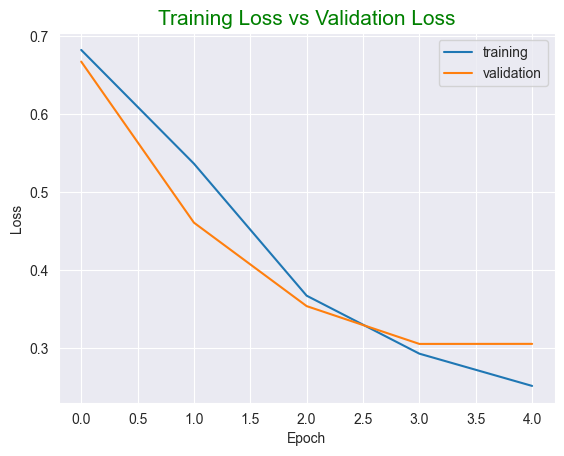

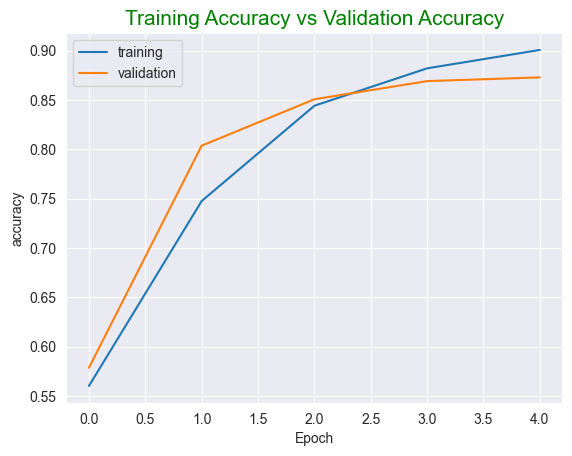

782/782 [==============================] - 19s 23ms/step

Classification Matrix:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88     12500
           1       0.90      0.83      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.88      0.87      0.87     25000
weighted avg       0.88      0.87      0.87     25000



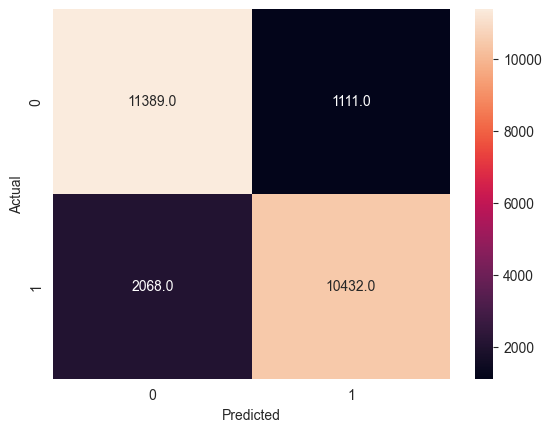

391/391 [==============================] - 13s 33ms/step - loss: 0.3051 - accuracy: 0.8728


In [22]:
metrics_score(X_imdb_test, y_imdb_test, X_imdb_train, y_imdb_train, 'RNN', imdb_model_list, model_rnn, imdb_rnn_history, batch_size)

In [23]:
pd.DataFrame(imdb_model_list,columns=['Model','Train_Loss','Train_Accuracy','Test_Loss','Test_Accuracy']).to_csv("imdb_model_list.csv",index=False)

### Simple LSTM Model.

In [20]:
# Clearing model
backend.clear_session()

model_lstm = Sequential()
model_lstm.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model_lstm.add(LSTM(100))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

checkpoint2 = ModelCheckpoint("model_weights2.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks2 = [checkpoint2,reduce_lr2]

model_lstm.summary()

2023-05-08 18:02:58.979079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Fit the model
imdb_lstm_history=model_lstm.fit(X_imdb_train, y_imdb_train, validation_data=(X_imdb_test, y_imdb_test), epochs=epoch, batch_size=batch_size, verbose=1, callbacks=callbacks2)

Epoch 1/5
391/391 [==============================] - ETA: 0s - loss: 0.4686 - accuracy: 0.7727
Epoch 1: saving model to model_weights2.h5
391/391 [==============================] - 177s 446ms/step - loss: 0.4686 - accuracy: 0.7727 - val_loss: 0.3352 - val_accuracy: 0.8569 - lr: 0.0010
Epoch 2/5
391/391 [==============================] - ETA: 0s - loss: 0.2627 - accuracy: 0.8952
Epoch 2: saving model to model_weights2.h5
391/391 [==============================] - 154s 393ms/step - loss: 0.2627 - accuracy: 0.8952 - val_loss: 0.2974 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 3/5
391/391 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.9161
Epoch 3: saving model to model_weights2.h5
391/391 [==============================] - 143s 366ms/step - loss: 0.2214 - accuracy: 0.9161 - val_loss: 0.2940 - val_accuracy: 0.8826 - lr: 0.0010
Epoch 4/5
391/391 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.9274
Epoch 4: saving model to model_weights2.h5
391/

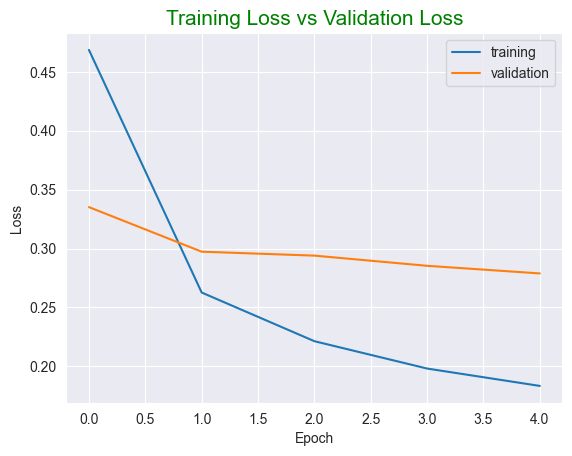

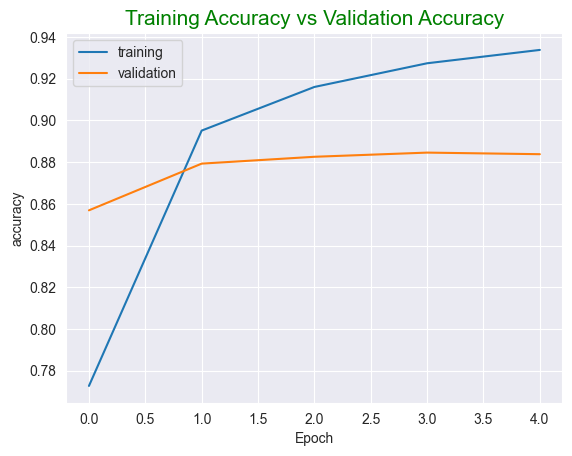

782/782 [==============================] - 48s 61ms/step

Classification Matrix:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88     12500
           1       0.88      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



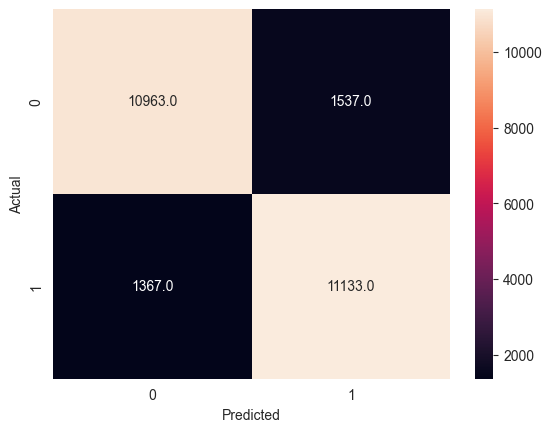

391/391 [==============================] - 36s 91ms/step - loss: 0.2789 - accuracy: 0.8838


In [22]:
metrics_score(X_imdb_test, y_imdb_test, X_imdb_train, y_imdb_train, 'LSTM', imdb_model_list, model_lstm, imdb_lstm_history, batch_size)

In [23]:
pd.DataFrame(imdb_model_list,columns=['Model','Train_Loss','Train_Accuracy','Test_Loss','Test_Accuracy']).to_csv("imdb_model_list.csv",index=False,header=False,mode='a')

### LSTM Model with dropout and recurrent_dropout.

In [20]:
# Clearing model
backend.clear_session()

model_lstm_with_dropout = Sequential()
model_lstm_with_dropout.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model_lstm_with_dropout.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm_with_dropout.add(Dense(1, activation='sigmoid'))

model_lstm_with_dropout.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

checkpoint3 = ModelCheckpoint("model_weights3.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
reduce_lr3 = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks3 = [checkpoint3,reduce_lr3]

model_lstm_with_dropout.summary()

2023-05-08 17:38:49.315771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Fit the model
imdb_lstm_with_dropout_history=model_lstm_with_dropout.fit(X_imdb_train, y_imdb_train, validation_data=(X_imdb_test, y_imdb_test), epochs=epoch, batch_size=batch_size, verbose=1, callbacks=callbacks3)

Epoch 1/5
391/391 [==============================] - ETA: 0s - loss: 0.4548 - accuracy: 0.7792
Epoch 1: saving model to model_weights3.h5
391/391 [==============================] - 242s 601ms/step - loss: 0.4548 - accuracy: 0.7792 - val_loss: 0.3263 - val_accuracy: 0.8595 - lr: 0.0010
Epoch 2/5
391/391 [==============================] - ETA: 0s - loss: 0.2654 - accuracy: 0.8959
Epoch 2: saving model to model_weights3.h5
391/391 [==============================] - 241s 616ms/step - loss: 0.2654 - accuracy: 0.8959 - val_loss: 0.2937 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 3/5
391/391 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.9154
Epoch 3: saving model to model_weights3.h5
391/391 [==============================] - 207s 529ms/step - loss: 0.2258 - accuracy: 0.9154 - val_loss: 0.2994 - val_accuracy: 0.8814 - lr: 0.0010
Epoch 4/5
391/391 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9248
Epoch 4: saving model to model_weights3.h5
391/

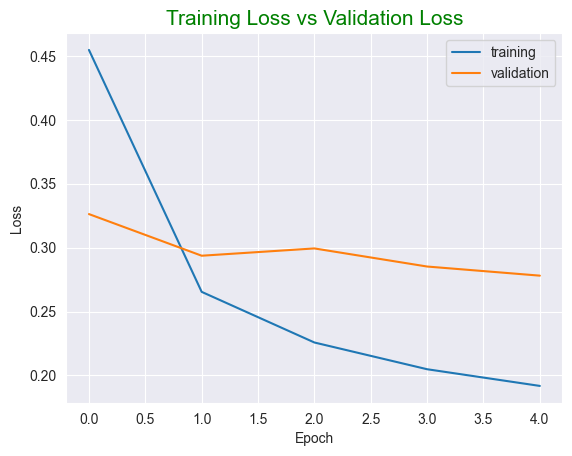

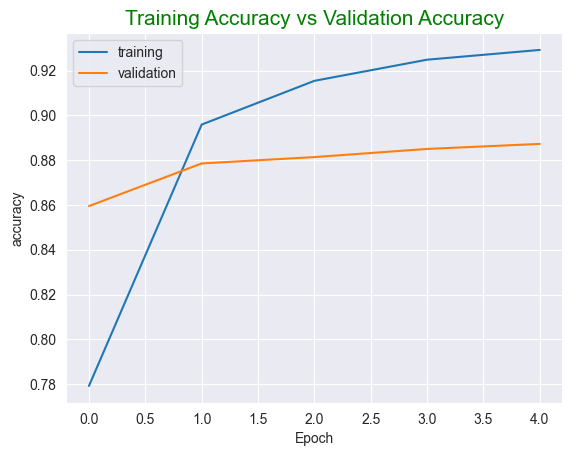

782/782 [==============================] - 54s 69ms/step

Classification Matrix:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89     12500
           1       0.88      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



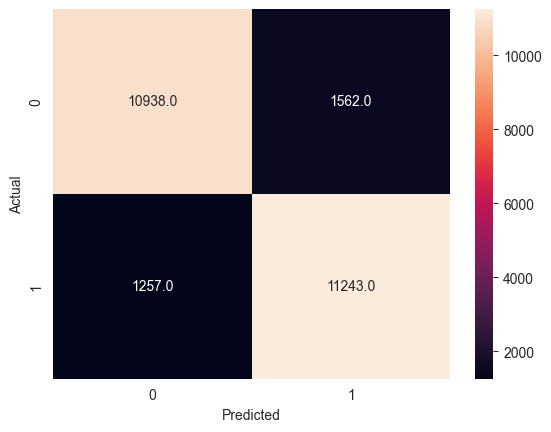

391/391 [==============================] - 31s 80ms/step - loss: 0.2781 - accuracy: 0.8872


In [22]:
metrics_score(X_imdb_test, y_imdb_test, X_imdb_train, y_imdb_train, 'LSTM_With_Dropout', imdb_model_list, model_lstm_with_dropout, imdb_lstm_with_dropout_history, batch_size)

In [23]:
pd.DataFrame(imdb_model_list,columns=['Model','Train_Loss','Train_Accuracy','Test_Loss','Test_Accuracy']).to_csv("imdb_model_list.csv",index=False,header=False,mode='a')

### LSTM Moeld with CNN Layer

In [20]:
# Clearing model
backend.clear_session()

model_lstm_cnn = Sequential()
model_lstm_cnn.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model_lstm_cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_lstm_cnn.add(MaxPooling1D(pool_size=2))
model_lstm_cnn.add(LSTM(100))
model_lstm_cnn.add(Dense(1, activation='sigmoid'))

model_lstm_cnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

checkpoint4 = ModelCheckpoint("model_weights4.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
reduce_lr4 = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks4 = [checkpoint4,reduce_lr4]

model_lstm_cnn.summary()

2023-05-08 18:19:04.787999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 conv1d (Conv1D)             (None, 500, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 250, 32)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
__________________________________________________

In [21]:
# Fit the model
imdb_lstm_cnn_history=model_lstm_cnn.fit(X_imdb_train, y_imdb_train, validation_data=(X_imdb_test, y_imdb_test), epochs=epoch, batch_size=batch_size, verbose=1, callbacks=callbacks4)

Epoch 1/5
391/391 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.7760
Epoch 1: saving model to model_weights4.h5
391/391 [==============================] - 107s 262ms/step - loss: 0.4485 - accuracy: 0.7760 - val_loss: 0.2989 - val_accuracy: 0.8732 - lr: 0.0010
Epoch 2/5
391/391 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9088
Epoch 2: saving model to model_weights4.h5
391/391 [==============================] - 96s 247ms/step - loss: 0.2381 - accuracy: 0.9088 - val_loss: 0.2974 - val_accuracy: 0.8824 - lr: 0.0010
Epoch 3/5
391/391 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9274
Epoch 3: saving model to model_weights4.h5
391/391 [==============================] - 94s 241ms/step - loss: 0.1992 - accuracy: 0.9274 - val_loss: 0.2975 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 4/5
391/391 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.9371
Epoch 4: saving model to model_weights4.h5
391/39

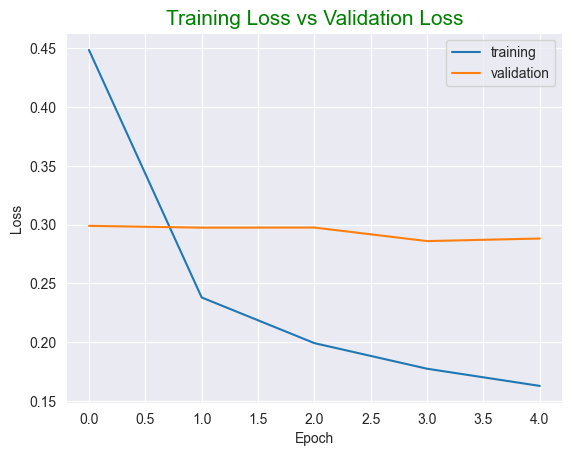

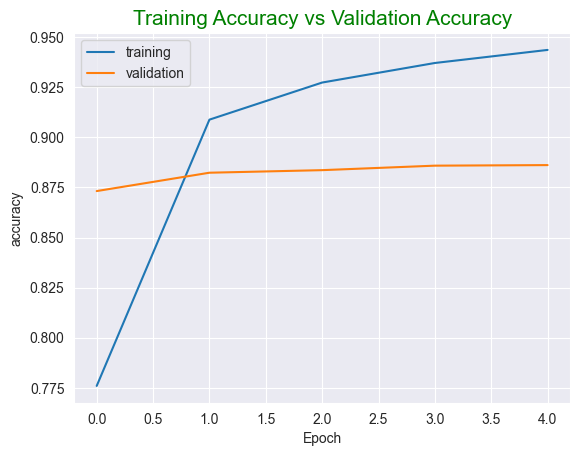

782/782 [==============================] - 29s 36ms/step

Classification Matrix:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89     12500
           1       0.89      0.88      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



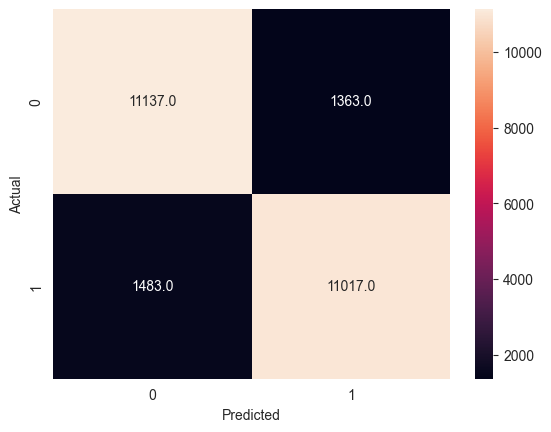

391/391 [==============================] - 23s 59ms/step - loss: 0.2882 - accuracy: 0.8862


In [22]:
metrics_score(X_imdb_test, y_imdb_test, X_imdb_train, y_imdb_train, 'LSTM_CNN', imdb_model_list, model_lstm_cnn, imdb_lstm_cnn_history, batch_size)

In [23]:
pd.DataFrame(imdb_model_list,columns=['Model','Train_Loss','Train_Accuracy','Test_Loss','Test_Accuracy']).to_csv("imdb_model_list.csv",index=False,header=False,mode='a')

In [24]:
imdb_model_list_df=pd.read_csv('imdb_model_list.csv')
imdb_model_list_df.sort_values(by=['Test_Accuracy','Train_Accuracy'], ascending=False)

,Model,Train_Loss,Train_Accuracy,Test_Loss,Test_Accuracy
2,LSTM_With_Dropout,0.176640,0.93752,0.278099,0.88724
3,LSTM_CNN,0.149329,0.94972,0.288168,0.88616
1,LSTM,0.176417,0.93840,0.278906,0.88384
0,RNN,0.234391,0.90900,0.305091,0.87284


## 6. Use the designed model to print the prediction on any one sample.

In [24]:
print("RNN model prediction",model_rnn.predict(X_imdb_test[1111].reshape(1,500), verbose=1))

1/1 [==============================] - 0s 44ms/step
RNN model prediction [[0.98800176]]


In [24]:
print("LSTM model prediction",model_lstm.predict(X_imdb_test[1111].reshape(1,500), verbose=1))

1/1 [==============================] - 0s 57ms/step
LSTM model prediction [[0.9903963]]


In [25]:
print("LSTM with Dropout model prediction",model_lstm_with_dropout.predict(X_imdb_test[1111].reshape(1,500), verbose=1))

1/1 [==============================] - 0s 61ms/step
LSTM with Dropout model prediction [[0.99310154]]


In [25]:
print("LSTM with CNN model prediction",model_lstm_cnn.predict(X_imdb_test[1111].reshape(1,500), verbose=1))

1/1 [==============================] - 0s 49ms/step
LSTM with CNN model prediction [[0.9965352]]


In [34]:
y_imdb_test[1111]

1

In [35]:
index_to_words(1111)

("Paragraph: actor at 25 we all know what he did as charles foster kane perhaps the most famous character in film history here he [OOV] a rare character of dim wit and not much intelligence something unfamiliar to those familiar with welles other great work instead of a slick wise tongue he speaks with a rough irish [OOV] rita hayworth his [OOV] married wife at the time plays an [OOV] married wife of a lawyer who puts welles in a spell and is able to draw him into a job that will take him to the limits of deception and [OOV] he is a large [OOV] who may have even murdered a man but the real mystery lies in the relationship between hayworth with stunning blonde hair and crippled [OOV] everett sloane mr [OOV] from citizen kane a creepy partner of [OOV] is along for the [OOV] around the country to set off a number of peculiar events that has welles' michael o'hara head spinning welles [OOV] the picture as o'hara but things are still unclear throughout see for yourself and realize that it t

############################

# PART-B

############################

## 1. Read and explore the data
## 2. Retain relevant columns

In [2]:
twitter_df = pd.read_json('https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json',lines=True)
twitter_df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [4]:
twitter_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
is_sarcastic,28619.0,NaN,NaN,NaN,0.476397,0.499451,0.0,0.0,0.0,1.0,1.0
headline,28619,28503,"'no way to prevent this,' says only nation whe...",12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
article_link,28619,28617,https://politics.theonion.com/nation-not-sure-...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Twitter dataset have 28619 records with 3 features.

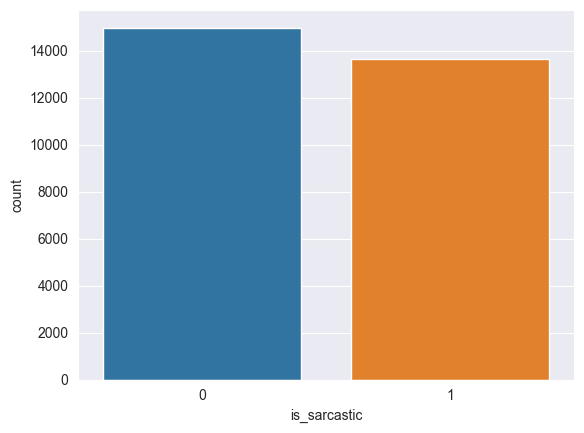

In [5]:
sns.countplot(twitter_df, x='is_sarcastic')
plt.show();

Twitter dataset `is_sarcastic` distribution:
- 14985(52.36%) records as not sarcastic(0)
- 13634(47.63%) records as sarcastic(1)

In [6]:
def extract_parent_link(data: str):
    if 'theonion.com' in data:
        return 'theonion.com'
    elif 'huffingtonpost.com' in data:
        return 'huffingtonpost.com'
    else:
        return 'Others'

In [7]:
twitter_df['article_parent_link']=twitter_df['article_link'].apply(extract_parent_link)
twitter_df.head()

,is_sarcastic,headline,article_link,article_parent_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,theonion.com
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,huffingtonpost.com
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,huffingtonpost.com
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,theonion.com
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,theonion.com


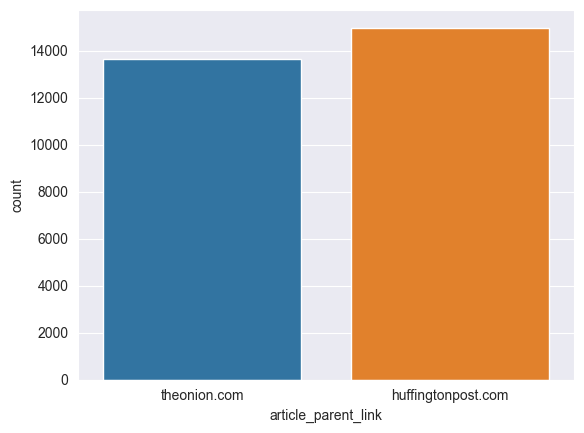

In [8]:
sns.countplot(twitter_df, x='article_parent_link')
plt.show();

Twitter dataset `article_parent_link` distribution:
- 14984(52.35%) records as huffingtonpost.com
- 13635(47.64%) records as theonion.com

In [9]:
# Copying original dataset
twitter_df_original = twitter_df.copy(deep=True)

In [10]:
# Removing irrelevant features
twitter_df.drop(columns=['article_parent_link','article_link'], axis=1, inplace=True)
twitter_df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


Twitter dataset is ready for analysis, so will perform some EDA.

In [11]:
# Checking if any empty values
twitter_df.isna().sum()

is_sarcastic    0
headline        0
dtype: int64

In [12]:
# Checking duplicates values
twitter_df.duplicated().value_counts()

False    28503
True       116
dtype: int64

In given twitter dataset, there are 116 duplicate values, which needs to be dropped.

In [13]:
twitter_df.drop_duplicates(inplace=True)
twitter_df.reset_index(inplace=True, drop=True)
twitter_df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [14]:
print(f"Twitter dataset have {twitter_df.shape[0]} records and {twitter_df.shape[1]} features")

Twitter dataset have 28503 records and 2 features


In [15]:
twitter_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
is_sarcastic,28503.0,NaN,NaN,NaN,0.475459,0.499406,0.0,0.0,0.0,1.0,1.0
headline,28503,28503,thirtysomething scientists unveil doomsday clo...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
def text_preprocessing(data: str):

    # Lowercase all textual data
    data = data.lower()

    # removing digits from text
    data = re.sub(r'\d+', '', data)

    # Cleaning the urls
    data = re.sub('https?://\S+|www\.\S+', '', data)

    # Cleaning the html elements
    data = re.sub(r'<.*?>', '', data)

    # Remove all extra white spaces
    data = re.sub(r'\s+', " ", data).strip()

    # removing punctuation from text
    data = "".join([char for char in data if char not in string.punctuation])
    return data

In [17]:
# Removing unwanted punctuation except '?'and'!' as they can be used for semantic analysis
twitter_df['headline']=twitter_df['headline'].apply(text_preprocessing)
twitter_df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails why congress is falling ...
2,0,eat your veggies deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word stream...


## 3. Get length of each sentence

In [18]:
twitter_df['headline_len']=twitter_df['headline'].str.len()
twitter_df.head()

,is_sarcastic,headline,headline_len
0,1,thirtysomething scientists unveil doomsday clo...,61
1,0,dem rep totally nails why congress is falling ...,77
2,0,eat your veggies deliciously different recipes,46
3,1,inclement weather prevents liar from getting t...,52
4,1,mother comes pretty close to using word stream...,59


In [19]:
# Maximum length text in dataset
twitter_df['headline_len'].max()

910

## 4. Define parameters

In [20]:
max_features = 5000
max_len = 300
embedding_size_50 = 50
embedding_size_100 = 100
embedding_size_200 = 200
embedding_size_300 = 300

## 5. Get indices for words
## 6. Create features and labels

In [21]:
tokenizer = Tokenizer(num_words = max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(twitter_df['headline'])

In [22]:
# generating features
X = tokenizer.texts_to_sequences(twitter_df['headline'])
X = pad_sequences(X, maxlen = max_len)
X.shape

(28503, 300)

In [23]:
# generating labels
y = np.asarray(twitter_df['is_sarcastic'])
y.shape

(28503,)

In [24]:
# Sample data for random index 1
print("Original text \n", twitter_df['headline'][1])

print("Indices of text: \n", X[1])

print("Label for text:",y[1])

Original text 
 dem rep totally nails why congress is falling short on gender racial equality
Indices of text: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

## 7. Get vocabulary size

In [25]:
word_index_map=tokenizer.word_index
word_index_map_size=len(word_index_map)
word_index_map_size

28833

In [26]:
# Printing 1st 10 mappings
list(islice(word_index_map.items(), 10))

[('<OOV>', 1),
 ('to', 2),
 ('of', 3),
 ('the', 4),
 ('in', 5),
 ('for', 6),
 ('a', 7),
 ('on', 8),
 ('and', 9),
 ('with', 10)]

## 8. Create a weight matrix using GloVe embeddings

In [27]:
ZipFile('glove.6B.zip').extractall()

In [28]:
# load the whole embedding into memory
embeddings_index_50 = dict()
for line in open('glove.6B.50d.txt',encoding='UTF8' ):
	values = line.split()
	word = values[0]
	embeddings_index_50[word] = np.asarray(values[1:], dtype='float32')
print('Loaded %s word vectors.' % len(embeddings_index_50))

# create a weight matrix for words in training docs
embedding_matrix_50 = np.zeros((word_index_map_size, embedding_size_50))
for word, i in word_index_map.items():
    embedding_vector = embeddings_index_50.get(word)
    if embedding_vector is not None:
        embedding_matrix_50[i] = embedding_vector
embedding_matrix_50.shape

Loaded 400000 word vectors.


(28833, 50)

In [27]:
# load the whole embedding into memory
embeddings_index_100 = dict()
for line in open('glove.6B.100d.txt',encoding='UTF8' ):
	values = line.split()
	word = values[0]
	embeddings_index_100[word] = np.asarray(values[1:], dtype='float32')
print('Loaded %s word vectors.' % len(embeddings_index_100))

# create a weight matrix for words in training docs
embedding_matrix_100 = np.zeros((word_index_map_size, embedding_size_100))
for word, i in word_index_map.items():
    embedding_vector = embeddings_index_100.get(word)
    if embedding_vector is not None:
        embedding_matrix_100[i] = embedding_vector
embedding_matrix_100.shape

Loaded 400000 word vectors.


(28833, 100)

In [27]:
# load the whole embedding into memory
embeddings_index_200 = dict()
for line in open('glove.6B.200d.txt',encoding='UTF8' ):
	values = line.split()
	word = values[0]
	embeddings_index_200[word] = np.asarray(values[1:], dtype='float32')
print('Loaded %s word vectors.' % len(embeddings_index_200))

# create a weight matrix for words in training docs
embedding_matrix_200 = np.zeros((word_index_map_size, embedding_size_200))
for word, i in word_index_map.items():
    embedding_vector = embeddings_index_200.get(word)
    if embedding_vector is not None:
        embedding_matrix_200[i] = embedding_vector
embedding_matrix_200.shape

Loaded 400000 word vectors.


(28833, 200)

In [27]:
# load the whole embedding into memory
embeddings_index_300 = dict()
for line in open('glove.6B.300d.txt',encoding='UTF8' ):
	values = line.split()
	word = values[0]
	embeddings_index_300[word] = np.asarray(values[1:], dtype='float32')
print('Loaded %s word vectors.' % len(embeddings_index_300))

# create a weight matrix for words in training docs
embedding_matrix_300 = np.zeros((word_index_map_size, embedding_size_300))
for word, i in word_index_map.items():
    embedding_vector = embeddings_index_300.get(word)
    if embedding_vector is not None:
        embedding_matrix_300[i] = embedding_vector
embedding_matrix_300.shape

Loaded 400000 word vectors.


(28833, 300)

## 9. Define and compile a Bidirectional LSTM model.
## 10. Fit the model and check the validation accuracy

In [28]:
X_twitter_train, X_twitter_test, y_twitter_train, y_twitter_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

In [29]:
print(f"X_train have {X_twitter_train.shape[0]} rows and {X_twitter_train.shape[1]} columns")
print(f"X_test have {X_twitter_test.shape[0]} rows and {X_twitter_test.shape[1]} columns")
print(f"y_train have {y_twitter_train.shape[0]} rows")
print(f"y_test have {y_twitter_test.shape[0]} rows")

X_train have 22802 rows and 300 columns
X_test have 5701 rows and 300 columns
y_train have 22802 rows
y_test have 5701 rows


In [30]:
# Defining Adam optimiser
adam = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)

In [31]:
def twitter_model_check(test_X, test_y, train_X, train_y, model_name, twitter_model_lists, model, model_history, batch_size):

    # Capturing learning history per epoch
    model_hist  = pd.DataFrame(model_history.history)
    model_hist['epoch'] = model_history.epoch

    # Plotting Loss at different epochs
    plt.title('Training Loss vs Validation Loss',fontsize=15,color="green")
    plt.plot(model_hist['loss'])
    plt.plot(model_hist['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(("training" , "validation") , loc ='best')
    plt.show()

    # Plotting Accuracy at different epochs
    plt.title('Training Accuracy vs Validation Accuracy',fontsize=15,color="green")
    plt.plot(model_hist['accuracy'])
    plt.plot(model_hist['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(("training" , "validation") , loc ='best')
    plt.show()

    # calculate score of training data
    eval_train = model.evaluate(train_X, train_y, batch_size=batch_size, verbose=1)

    # calculate score of testing data
    eval_test = model.evaluate(test_X, test_y, batch_size=batch_size, verbose=1)

    y_pred = model.predict(np.array(test_X), verbose=1)
    y_pred = [1 if z>x else 0 for x,z in y_pred]

    print("\nClassification Matrix:\n",classification_report(test_y, y_pred))

    sns.heatmap(confusion_matrix(test_y, y_pred), annot = True,  fmt = '.1f')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    twitter_model_lists.append([model_name, eval_train[0], eval_train[1], eval_test[0], eval_test[1]])

### Model training with Glove embedding 50

In [36]:
# Clearing model
backend.clear_session()

# define model with 50 embedding
model_twitter_50 = Sequential()

model_twitter_50.add(Embedding(embedding_matrix_50.shape[0], output_dim=embedding_size_50, weights=[embedding_matrix_50], input_length=max_len, trainable=True))
model_twitter_50.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model_twitter_50.add(Dense(100,activation='relu'))
model_twitter_50.add(Dense(2, activation='softmax'))

# compile the model
model_twitter_50.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_twitter_50 = ModelCheckpoint("model_weights_twitter_50.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
reduce_lr_twitter_50 = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks_twitter_50 = [checkpoint_twitter_50,reduce_lr_twitter_50]

# summarize the model
model_twitter_50.summary()

2023-05-08 10:43:12.081421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 50)           1441650   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              120800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,582,752
Trainable params: 1,582,752
Non-trainable params: 0
_________________________________________________________________


In [37]:
twitter_history_50 = model_twitter_50.fit(X_twitter_train,y_twitter_train,batch_size=64, validation_data=(X_twitter_test, y_twitter_test), epochs=5, verbose=1, callbacks=callbacks_twitter_50)

Epoch 1/5
357/357 [==============================] - ETA: 0s - loss: 0.4314 - accuracy: 0.7925
Epoch 1: saving model to model_weights_twitter_50.h5
357/357 [==============================] - 195s 526ms/step - loss: 0.4314 - accuracy: 0.7925 - val_loss: 0.3217 - val_accuracy: 0.8542 - lr: 0.0100
Epoch 2/5
357/357 [==============================] - ETA: 0s - loss: 0.2735 - accuracy: 0.8850
Epoch 2: saving model to model_weights_twitter_50.h5
357/357 [==============================] - 187s 524ms/step - loss: 0.2735 - accuracy: 0.8850 - val_loss: 0.3127 - val_accuracy: 0.8683 - lr: 0.0100
Epoch 3/5
357/357 [==============================] - ETA: 0s - loss: 0.2319 - accuracy: 0.9043
Epoch 3: saving model to model_weights_twitter_50.h5
357/357 [==============================] - 185s 518ms/step - loss: 0.2319 - accuracy: 0.9043 - val_loss: 0.3061 - val_accuracy: 0.8725 - lr: 0.0100
Epoch 4/5
357/357 [==============================] - ETA: 0s - loss: 0.2088 - accuracy: 0.9154
Epoch 4: saving m

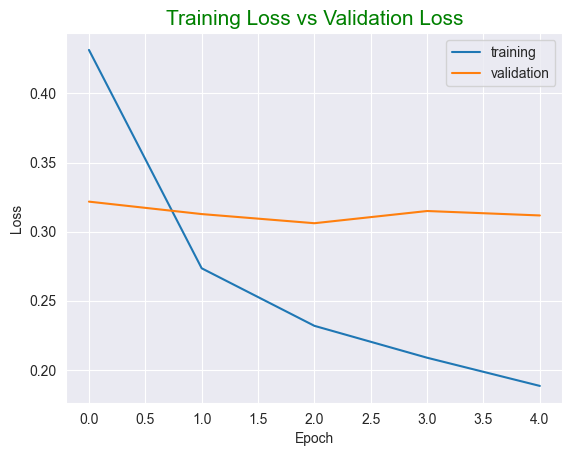

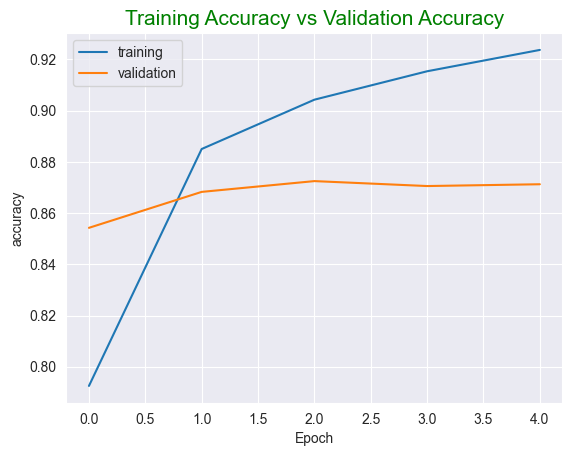

179/179 [==============================] - 13s 68ms/step

Classification Matrix:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      2956
           1       0.88      0.85      0.86      2745

    accuracy                           0.87      5701
   macro avg       0.87      0.87      0.87      5701
weighted avg       0.87      0.87      0.87      5701



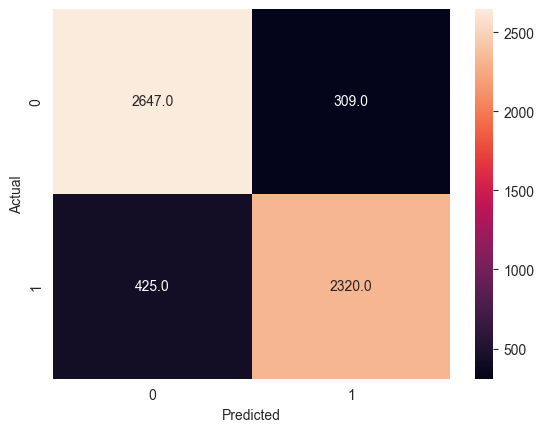

In [38]:
twitter_model_check(X_twitter_test, y_twitter_test, X_twitter_train, y_twitter_train, "Glove-50 Model", twitter_model_list, model_twitter_50, twitter_history_50, 64)

In [42]:
pd.DataFrame(twitter_model_list,columns=['Model','Train_Loss','Train_Accuracy','Test_Loss','Test_Accuracy']).to_csv("twitter_model_list.csv",index=False)

### Model training with Glove embedding 100

In [34]:
# Clearing model
backend.clear_session()

# define model with 100 embedding
model_twitter_100 = Sequential()

model_twitter_100.add(Embedding(embedding_matrix_100.shape[0], output_dim=embedding_size_100, weights=[embedding_matrix_100], input_length=max_len, trainable=True))
model_twitter_100.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model_twitter_100.add(Dense(100,activation='relu'))
model_twitter_100.add(Dense(2, activation='softmax'))

# compile the model
model_twitter_100.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_twitter_100 = ModelCheckpoint("model_weights_twitter_100.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
reduce_lr_twitter_100 = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks_twitter_100 = [checkpoint_twitter_100,reduce_lr_twitter_100]

# summarize the model
model_twitter_100.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          2883300   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 3,064,402
Trainable params: 3,064,402
Non-trainable params: 0
_________________________________________________________________


In [35]:
twitter_history_100 = model_twitter_100.fit(X_twitter_train,y_twitter_train,batch_size=64, validation_data=(X_twitter_test, y_twitter_test), epochs=5, verbose=1, callbacks=callbacks_twitter_100)

Epoch 1/5
357/357 [==============================] - ETA: 0s - loss: 0.4087 - accuracy: 0.8084
Epoch 1: saving model to model_weights_twitter_100.h5
357/357 [==============================] - 255s 691ms/step - loss: 0.4087 - accuracy: 0.8084 - val_loss: 0.3298 - val_accuracy: 0.8535 - lr: 0.0100
Epoch 2/5
357/357 [==============================] - ETA: 0s - loss: 0.2492 - accuracy: 0.8937
Epoch 2: saving model to model_weights_twitter_100.h5
357/357 [==============================] - 232s 649ms/step - loss: 0.2492 - accuracy: 0.8937 - val_loss: 0.3172 - val_accuracy: 0.8674 - lr: 0.0100
Epoch 3/5
357/357 [==============================] - ETA: 0s - loss: 0.2046 - accuracy: 0.9172
Epoch 3: saving model to model_weights_twitter_100.h5
357/357 [==============================] - 253s 707ms/step - loss: 0.2046 - accuracy: 0.9172 - val_loss: 0.3179 - val_accuracy: 0.8679 - lr: 0.0100
Epoch 4/5
357/357 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9320
Epoch 4: savin

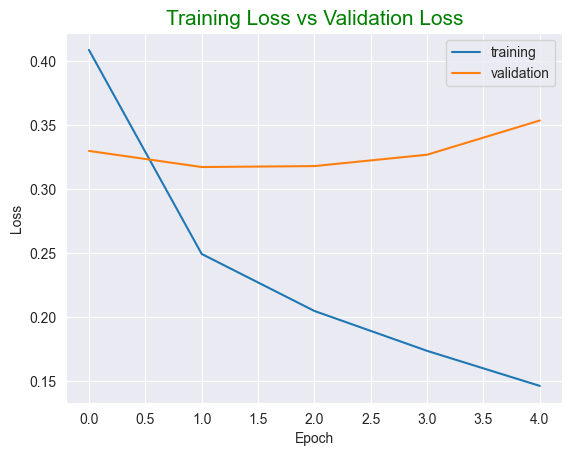

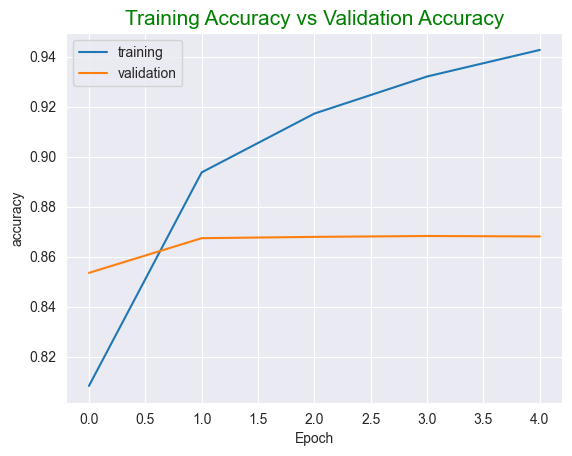

179/179 [==============================] - 13s 73ms/step

Classification Matrix:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2956
           1       0.86      0.86      0.86      2745

    accuracy                           0.87      5701
   macro avg       0.87      0.87      0.87      5701
weighted avg       0.87      0.87      0.87      5701



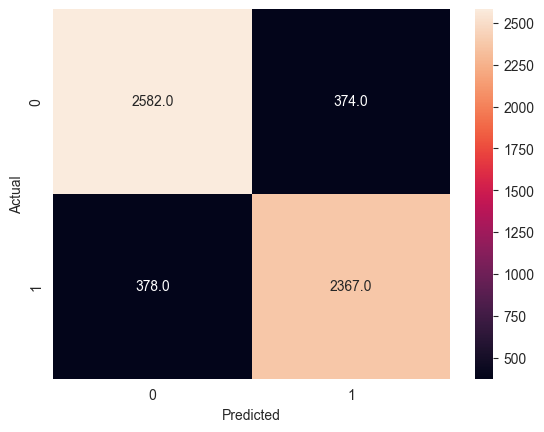

In [41]:
twitter_model_check(X_twitter_test, y_twitter_test, X_twitter_train, y_twitter_train, "Glove-100 Model", twitter_model_list, model_twitter_100, twitter_history_100, 64)

In [42]:
pd.DataFrame(twitter_model_list,columns=['Model','Train_Loss','Train_Accuracy','Test_Loss','Test_Accuracy']).to_csv("twitter_model_list.csv",index=False,header=False,mode='a')

### Model training with Glove embedding 200

In [32]:
# Clearing model
backend.clear_session()

# define model with 200 embedding
model_twitter_200 = Sequential()

model_twitter_200.add(Embedding(embedding_matrix_200.shape[0], output_dim=embedding_size_200, weights=[embedding_matrix_200], input_length=max_len, trainable=True))
model_twitter_200.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model_twitter_200.add(Dense(100,activation='relu'))
model_twitter_200.add(Dense(2, activation='softmax'))

# compile the model
model_twitter_200.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_twitter_200 = ModelCheckpoint("model_weights_twitter_200.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
reduce_lr_twitter_200 = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks_twitter_200 = [checkpoint_twitter_200,reduce_lr_twitter_200]

# summarize the model
model_twitter_200.summary()

2023-05-08 12:28:03.677250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 200)          5766600   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              240800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 6,027,702
Trainable params: 6,027,702
Non-trainable params: 0
_________________________________________________________________


In [33]:
twitter_history_200 = model_twitter_200.fit(X_twitter_train,y_twitter_train,batch_size=64, validation_data=(X_twitter_test, y_twitter_test), epochs=5, verbose=1, callbacks=callbacks_twitter_200)

Epoch 1/5
357/357 [==============================] - ETA: 0s - loss: 0.3942 - accuracy: 0.8145
Epoch 1: saving model to model_weights_twitter_200.h5
357/357 [==============================] - 440s 1s/step - loss: 0.3942 - accuracy: 0.8145 - val_loss: 0.3084 - val_accuracy: 0.8676 - lr: 0.0100
Epoch 2/5
357/357 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9052
Epoch 2: saving model to model_weights_twitter_200.h5
357/357 [==============================] - 686s 2s/step - loss: 0.2248 - accuracy: 0.9052 - val_loss: 0.3021 - val_accuracy: 0.8707 - lr: 0.0100
Epoch 3/5
357/357 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.9319
Epoch 3: saving model to model_weights_twitter_200.h5
357/357 [==============================] - 391s 1s/step - loss: 0.1661 - accuracy: 0.9319 - val_loss: 0.3535 - val_accuracy: 0.8693 - lr: 0.0100
Epoch 4/5
357/357 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9507
Epoch 4: saving model t

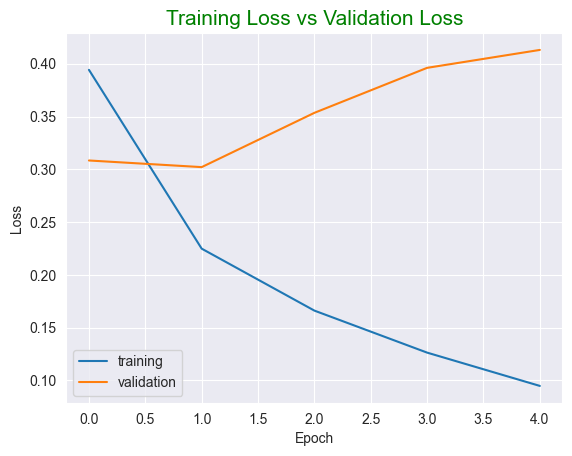

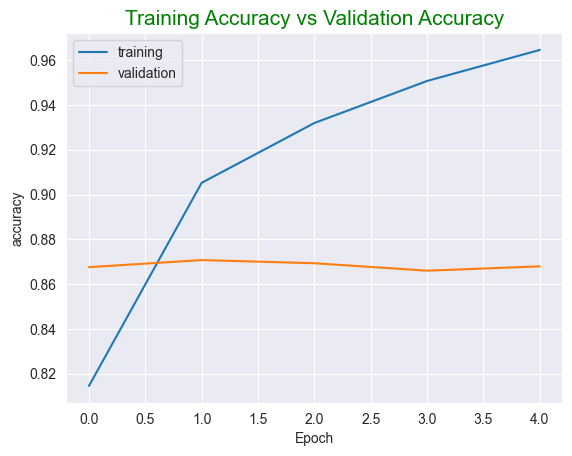

179/179 [==============================] - 23s 123ms/step

Classification Matrix:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      2956
           1       0.87      0.85      0.86      2745

    accuracy                           0.87      5701
   macro avg       0.87      0.87      0.87      5701
weighted avg       0.87      0.87      0.87      5701



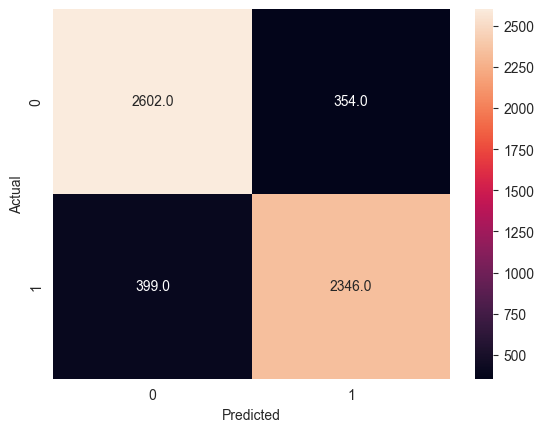

In [34]:
twitter_model_check(X_twitter_test, y_twitter_test, X_twitter_train, y_twitter_train, "Glove-200 Model", twitter_model_list, model_twitter_200, twitter_history_200, 64)

In [35]:
pd.DataFrame(twitter_model_list,columns=['Model','Train_Loss','Train_Accuracy','Test_Loss','Test_Accuracy']).to_csv("twitter_model_list.csv",index=False,header=False,mode='a')

### Model training with Glove embedding 300

In [32]:
# Clearing model
backend.clear_session()

# define model with 300 embedding
model_twitter_300 = Sequential()

model_twitter_300.add(Embedding(embedding_matrix_300.shape[0], output_dim=embedding_size_300, weights=[embedding_matrix_300], input_length=max_len, trainable=True))
model_twitter_300.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model_twitter_300.add(Dense(100,activation='relu'))
model_twitter_300.add(Dense(2, activation='softmax'))

# compile the model
model_twitter_300.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_twitter_300 = ModelCheckpoint("model_weights_twitter.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
reduce_lr_twitter_300 = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks_twitter_300 = [checkpoint_twitter_300,reduce_lr_twitter_300]

# summarize the model
model_twitter_300.summary()

2023-05-08 13:10:54.517145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          8649900   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              320800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 8,991,002
Trainable params: 8,991,002
Non-trainable params: 0
_________________________________________________________________


In [33]:
twitter_history_300 = model_twitter_300.fit(X_twitter_train,y_twitter_train,batch_size=64, validation_data=(X_twitter_test, y_twitter_test), epochs=5, verbose=1, callbacks=callbacks_twitter_300)

Epoch 1/5
357/357 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.8124
Epoch 1: saving model to model_weights_twitter.h5
357/357 [==============================] - 659s 2s/step - loss: 0.4048 - accuracy: 0.8124 - val_loss: 0.3086 - val_accuracy: 0.8683 - lr: 0.0100
Epoch 2/5
357/357 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.9092
Epoch 2: saving model to model_weights_twitter.h5
357/357 [==============================] - 790s 2s/step - loss: 0.2210 - accuracy: 0.9092 - val_loss: 0.3067 - val_accuracy: 0.8700 - lr: 0.0100
Epoch 3/5
357/357 [==============================] - ETA: 0s - loss: 0.1482 - accuracy: 0.9415
Epoch 3: saving model to model_weights_twitter.h5
357/357 [==============================] - 680s 2s/step - loss: 0.1482 - accuracy: 0.9415 - val_loss: 0.3502 - val_accuracy: 0.8707 - lr: 0.0100
Epoch 4/5
357/357 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9597
Epoch 4: saving model to model_weig

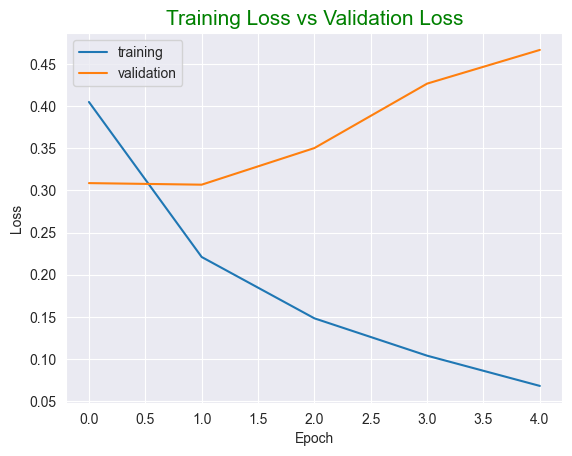

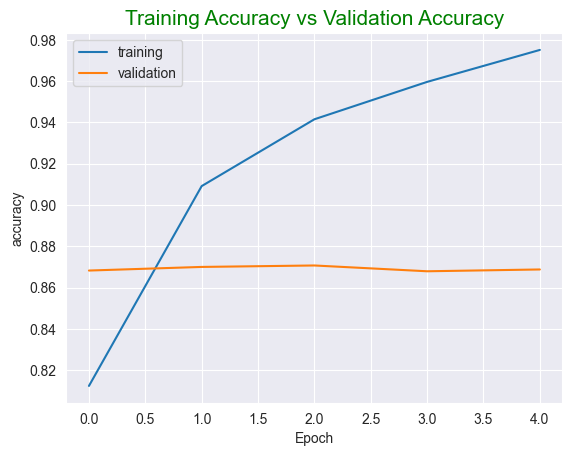

179/179 [==============================] - 35s 192ms/step

Classification Matrix:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      2956
           1       0.87      0.86      0.86      2745

    accuracy                           0.87      5701
   macro avg       0.87      0.87      0.87      5701
weighted avg       0.87      0.87      0.87      5701



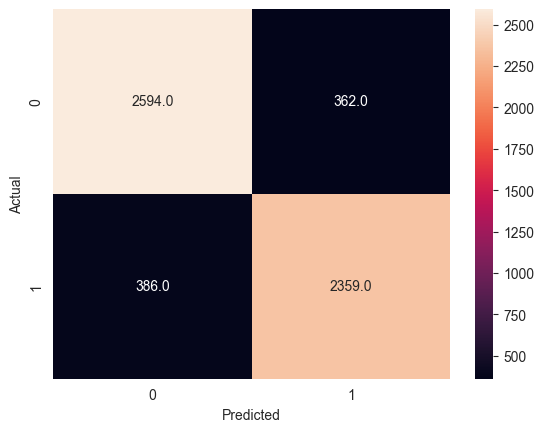

In [34]:
twitter_model_check(X_twitter_test, y_twitter_test, X_twitter_train, y_twitter_train, "Glove-300 Model", twitter_model_list, model_twitter_300, twitter_history_300, 64)

In [35]:
pd.DataFrame(twitter_model_list,columns=['Model','Train_Loss','Train_Accuracy','Test_Loss','Test_Accuracy']).to_csv("twitter_model_list.csv",index=False,header=False,mode='a')

In [36]:
twitter_model_list_df=pd.read_csv('twitter_model_list.csv')
twitter_model_list_df.sort_values(by=['Test_Accuracy','Train_Accuracy'], ascending=False)

,Model,Train_Loss,Train_Accuracy,Test_Loss,Test_Accuracy
0,Glove-50 Model,0.151474,0.942768,0.311702,0.871251
3,Glove-300 Model,0.053885,0.980703,0.466584,0.868795
1,Glove-100 Model,0.126031,0.952285,0.353569,0.868093
2,Glove-200 Model,0.077016,0.972546,0.413104,0.867918
